# CMUA Watermark Testing & Analysis

In [1]:
import torch
import os
import numpy as np
import skimage.io
import torch.nn.functional as F
import image_transforms
import IPython.display
from IPython.display import clear_output
import PIL.Image
from io import BytesIO
import matplotlib.pyplot as plt
import re
from pathlib import Path

from zipfile import ZipFile

# Set Variables

In [2]:
img_dir = "sample_images"
working_dir = str(Path.cwd()) 
img_dir = working_dir + '\\sample_images\\celeba_data.zip'
target_image_dir = "sample_target_images"
out_dir = "out_dir"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Models

In [3]:
encoder_model = torch.load("perturbation.pt", map_location=torch.device('cpu'))

In [4]:
def find_image_paths(image_dir):
    image_paths = []

    if image_dir == "sample_images" or image_dir == "alternate_deepfakes" or image_dir == "sample_target_images":
        for img_file in os.listdir(image_dir):
            if img_file.endswith(".png") or img_file.endswith(".jpg"):
                image_paths.append(os.path.join(image_dir, img_file))
    else:
        with ZipFile(img_dir) as zip_archive: 
            for img_file in zip_archive.filelist:
                image_paths.append(os.path.join(image_dir, img_file.filename))
    
    image_paths.sort()
    return image_paths

def load_images(image_filepaths, img_size=256):
    image_batch_np = []
    for file_path in image_filepaths:
        image_from_file = skimage.io.imread(file_path)/255.0
        
        image_from_file = skimage.transform.resize(image_from_file, (300,300),
                                                   preserve_range=True, mode='constant')
        
        image_from_file = image_from_file[:, :, :3]
        image_batch_np.append(image_from_file)
    image_batch_np = np.stack(image_batch_np, axis=0)
    image_batch = torch.from_numpy(image_batch_np).float()
    image_batch = image_batch.permute(0, 3, 1, 2)

    h, w = image_batch.shape[2:]
    if h > w:
        image_batch = image_batch[:, :, int((h-w)/2):int((h+w)/2), :]
    elif w > h:
        image_batch = image_batch[:, :, :, int((w-h)/2):int((w+h)/2)]
    image_batch = F.interpolate(image_batch, size=(img_size, img_size), mode='bilinear', align_corners=True)

    return image_batch

In [5]:
def save_images(image_batch, out_dir, prefix=""):
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    
    image_paths = []
    for img_idx in range(image_batch.shape[0]):
        image_np = image_batch[img_idx].permute(1, 2, 0).cpu().numpy()
        image_np = np.uint8(image_np*255.)
        file_path = os.path.join(out_dir, "{}_{}.png".format(prefix, img_idx))
        PIL.Image.fromarray(image_np).save(file_path)
        image_paths.append(file_path)
    
    return image_paths

In [6]:
def find_image_paths(image_dir):
  
    image_paths = []

    if image_dir == "sample_images" or image_dir == "alternate_deepfakes" or image_dir == "sample_target_images":
        for img_file in os.listdir(image_dir):
            if img_file.endswith(".png") or img_file.endswith(".jpg"):
                image_paths.append(os.path.join(image_dir, img_file))
    else:
        with ZipFile(img_dir) as zip_archive: 
            for img_file in zip_archive.filelist:
                image_paths.append(os.path.join(image_dir, img_file.filename))
    
    image_paths.sort()
    return image_paths

In [7]:
def showarray(a, fmt='png'):
    """
    takes a numpy array (0 to 1) of size h, w, 3
    """
    a = np.uint8(a*255.)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

# Load Images

In [8]:
original_image_paths = find_image_paths(img_dir)
print(len(original_image_paths))
original_image_paths = original_image_paths[:50]
images = load_images(original_image_paths)

images = images.to(device)

202603


# Watermark Images

In [9]:
import torchvision.utils as vutils

i = 0 
encoded_images = []

with torch.no_grad():
    
    for img in images:
        out_file = './out_dir/signed_images/ ' + '_' + str(i) + '.jpg'       
        watermarked_image = img + (0.1 *encoder_model)
        encoded_images.append(watermarked_image)
        vutils.save_image(watermarked_image,out_file) 

        i = i + 1      
    
    signed_image_dir = os.path.join(out_dir, "signed_images")
    
encoded_image_paths = []

for root, dirs, files in os.walk(signed_image_dir):
    for fileName in files:
        encoded_image_paths.append(os.path.join(root, fileName))

# Display Watermark

Original Image, Signed Image, Perturbation (Scaled for Visualization)


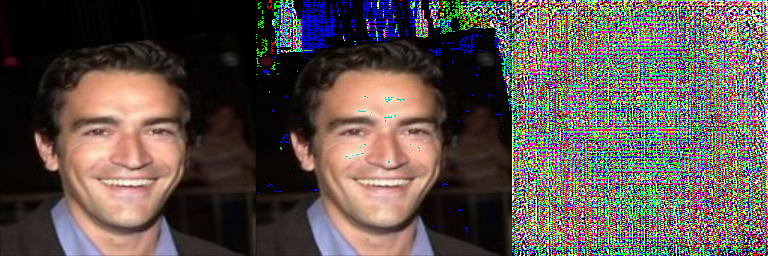

In [10]:
original_image_numpy = img.permute(1, 2, 0).cpu().numpy() 
encoded_image_numpy = watermarked_image.permute(1, 2, 0).cpu().numpy()
residual = (encoded_image_numpy - original_image_numpy)
rmin, rmax = np.min(residual), np.max(residual)
residual_scaled = (residual-rmin)/(rmax - rmin)
original_encoded_image = np.concatenate( (original_image_numpy, encoded_image_numpy, residual_scaled), axis=1)
print("Original Image,", "Signed Image,", "Perturbation (Scaled for Visualization)")
showarray(original_encoded_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


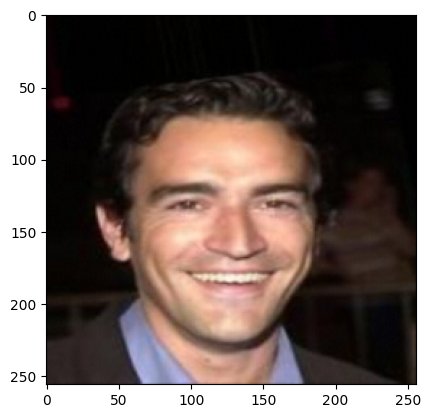

In [11]:
plt.imshow( watermarked_image.permute(1, 2, 0)  )

In [12]:
encoded_image_paths = []

for root, dirs, files in os.walk(signed_image_dir):
    for fileName in files:
        encoded_image_paths.append(os.path.join(root, fileName))
        encoded_image_paths.sort()

# Split Dataset in half

In [13]:
total_images = len(encoded_image_paths)
print('Total Images: ', total_images)

half = int(total_images/2)
benign_encoded_image_paths = encoded_image_paths[:half]
mal_encoded_image_paths = encoded_image_paths[half:]

print('Benign Transformations: ', len(benign_encoded_image_paths))
print('Malicous Transformations: ', len(mal_encoded_image_paths))

Total Images:  50
Benign Transformations:  25
Malicous Transformations:  25


In [14]:
length = total_images
benign = [1] * len(benign_encoded_image_paths)
malicous = [0] * len(mal_encoded_image_paths)

y_actual = 5*benign + malicous

y_pred = []

# Make Benign Transformations

In [15]:
benign_dir = os.path.join(out_dir, "benign_transformed_images")
benign_tranform_list, benign_file_paths = image_transforms.apply_benign_transforms(benign_encoded_image_paths, benign_dir)

Benign Transformation total:  25


# Calculate Loss

In [16]:
l2s_benign_watermarked = []

In [17]:
for key in benign_file_paths:
    
    images = benign_file_paths[key]
    for b_img in images:           
        folder = 'out_dir\\signed_images\\ _'
        split = b_img.split('\\')
        split2 = re.search(r"\d+(\.\d+)?", split[2]).group(0)
        img_number = int(split2)
        
        watermark_img_path = folder + str(img_number) + '.jpg'
        
        image_from_file = skimage.io.imread(watermark_img_path) / 255.0
        image_from_file = skimage.transform.resize(image_from_file, (300, 300),
                                               preserve_range=True, mode='constant')
        image_from_file = image_from_file[:, :, :3]
        watermarked_image = torch.tensor(image_from_file).float()

        
        image_from_file = skimage.io.imread(b_img) / 255.0
        image_from_file = skimage.transform.resize(image_from_file, (300, 300),
                                               preserve_range=True, mode='constant')
        image_from_file = image_from_file[:, :, :3]
        benign_img = torch.from_numpy(image_from_file).float()

        l2_error = F.mse_loss(watermarked_image, benign_img)
        l2s_benign_watermarked.append(l2_error)
        
        if (l2_error < 0.05):
            y_pred.append(1)
        else: 
            y_pred.append(0)
            print('\t identified as malcious', l2_error)
            print("\t watermark: ", watermark_img_path)
            print("\t benign: ", b_img)

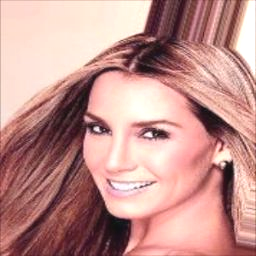

Transform : aden


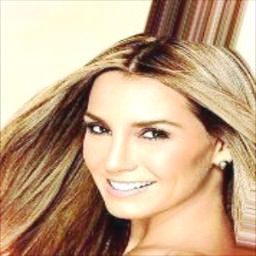

Transform : brooklyn


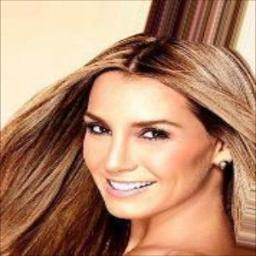

Transform : JPEG-75


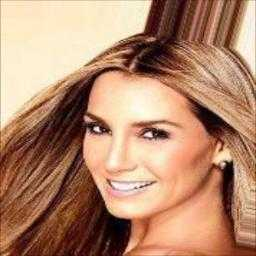

Transform : JPEG-50


In [18]:
for key in benign_file_paths:
    images = benign_file_paths[key]
    if key != 'None':
        for img in images[:1]:   
            IPython.display.display(IPython.display.Image(img))
            print("Transform : {}".format(key))

# Make Malicious Transformations

In [19]:
mal_dir = os.path.join(out_dir, "mal_transformed_images")
target_image_paths = find_image_paths(target_image_dir)

In [20]:
unable_to_malicously_swap, mal_tranform_list, mal_file_paths, watermarked_l2s, mal_encoded_image_paths= image_transforms.apply_malicious_transforms(
    mal_encoded_image_paths, target_image_paths[1:2], mal_dir)

Error in shallowfakes
Error in shallowfakes


In [21]:
len(unable_to_malicously_swap)

2

## L2 score between watermarked image and deepfake

In [22]:
np.array(watermarked_l2s)

array([0.00158615, 0.00113492, 0.00168661, 0.00275765, 0.0027663 ,
       0.00456033, 0.00135614, 0.00328665, 0.00879532, 0.00119279,
       0.00139489, 0.00202935, 0.00105186, 0.00143484, 0.00120521,
       0.00633346, 0.00223253, 0.00540908, 0.00123814, 0.00259222,
       0.00145972, 0.00610367, 0.00179252], dtype=float32)

### Calculate Loss

In [24]:
for l2_error in watermarked_l2s: 
    if (l2_error < 0.05):
            y_pred.append(1)
    else: 
        y_pred.append(0)
        print(L2)

In [25]:
# Adjust length to the images that were able to be swapped. 
if(unable_to_malicously_swap): 
    l = len(y_actual) - len(unable_to_malicously_swap) 
    y_actual = y_actual[:l]

# Display FaceApp Malicous Change

face_swap


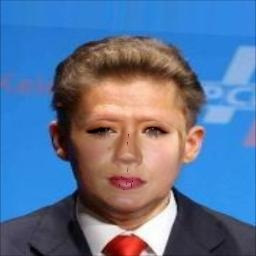

In [26]:
for key in mal_tranform_list:
    print(key)
    paths = mal_file_paths[key]
    for path in paths[:1]: 
        IPython.display.display(IPython.display.Image(path))

# Analyze Watermark Method

In [27]:
assert(len(y_pred) == len(y_actual))

In [28]:
pred = y_pred 
actual = y_actual

## AUC

In [29]:
import numpy as np
from sklearn import metrics

pred = y_pred
actual = y_actual 

auc = metrics.roc_auc_score(actual, pred)
auc

0.5

### Confusion Matrix

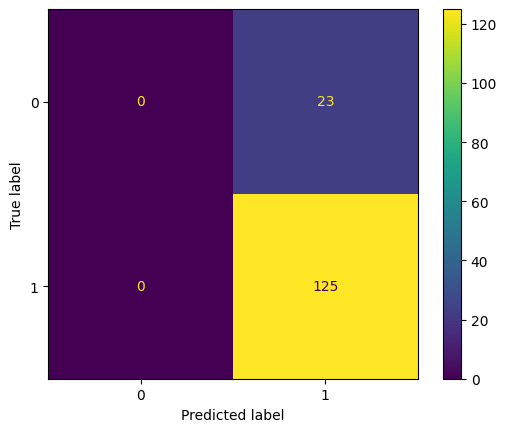

In [30]:
import matplotlib.pyplot as plt

import numpy as np 
from sklearn import metrics 

confusion_matrix = metrics.confusion_matrix(actual, pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix) #, display_labels = [False, True]
cm_display.plot()
plt.show()

# Calculate L2 Loss
Calculate L2 Loss for original images and deepfake

In [31]:
new_original_image_paths = []

length_num = [0] * 6
s = ''
for num in length_num: 
    s = s + str(num)
    
for x in original_image_paths: 
    split = x.split('\\')
    split2 = re.search(r"\d+(\.\d+)?", split[9]).group(0)
    img_number = int(split2)
    
    leading_zeroes = 0 - len(str(img_number))
    str_img_num =  s[:leading_zeroes] + str(img_number)
       
    fn = '\\sample_images\\celeba_data.zip\\img_align_celeba/img_align_celeba/' + str_img_num + '.jpg'
    folder = str(Path.cwd()) + fn
    new_original_image_paths.append(folder)


In [32]:
w_watermark = mal_encoded_image_paths
w_o_watermark = new_original_image_paths

In [33]:
org_images = load_images(w_o_watermark)

## Malicously swap original, non-watermarked images

In [34]:
i = 0 
original_images = []
with torch.no_grad():
    
    for img in org_images:
        out_file = './out_dir/original_images/ ' + '_' + str(i) + '.jpg'
        original_images.append(img)
        vutils.save_image(img,out_file) 
        i = i + 1      
    
    original_image_dir = os.path.join(out_dir, "original_images")
    
original_image_paths_ = []

for root, dirs, files in os.walk(original_image_dir):
    for fileName in files:
        original_image_paths_.append(os.path.join(root, fileName))

### Get L2s for all non-watermarked deepake images

In [35]:
unable_to_malicously_swap, mal_tranform_list, mal_file_paths, original_l2s, null = image_transforms.apply_malicious_transforms(
    original_image_paths_, target_image_paths[1:2], mal_dir)

Error in shallowfakes
Error in shallowfakes
Error in shallowfakes
Error in shallowfakes


In [36]:
unable_to_malicously_swap

['out_dir\\original_images\\ _2',
 'out_dir\\original_images\\ _3',
 'out_dir\\original_images\\ _35',
 'out_dir\\original_images\\ _36']

In [37]:
print(len(unable_to_malicously_swap))

4


### Get L2s for all watermarked deepake images

In [38]:
mal_encoded_image_paths = encoded_image_paths
unable_to_malicously_swap, mal_tranform_list, mal_file_paths, watermarked_l2s, mal_encoded_image_paths= image_transforms.apply_malicious_transforms(
    mal_encoded_image_paths, target_image_paths[1:2], mal_dir)

Error in shallowfakes
Error in shallowfakes
Error in shallowfakes
Error in shallowfakes


In [39]:
unable_to_malicously_swap

['out_dir\\signed_images\\ _2',
 'out_dir\\signed_images\\ _3',
 'out_dir\\signed_images\\ _35',
 'out_dir\\signed_images\\ _36']

# Calculate difference between L2 for original images that have been deepfaked  and watermarked 

In [40]:
difference = np.absolute(np.array(original_l2s) - np.array(watermarked_l2s))
difference

array([3.8454705e-04, 1.4100992e-04, 1.0181917e-03, 7.6852273e-05,
       3.2109208e-05, 1.2597651e-05, 1.0991469e-05, 3.6288635e-05,
       1.2161676e-04, 1.4083635e-05, 1.2413529e-04, 7.1220798e-05,
       4.5401743e-05, 1.1081516e-05, 1.4728797e-04, 9.5391879e-05,
       1.2510456e-05, 2.1918328e-05, 4.3524895e-05, 1.1524239e-03,
       1.5484169e-05, 1.2985035e-04, 6.4084074e-05, 1.1801836e-05,
       1.9771047e-05, 2.6035123e-06, 3.8919970e-06, 2.3006694e-05,
       1.8299604e-04, 4.4538756e-05, 2.5966670e-05, 1.2255120e-03,
       1.7296989e-06, 2.9582414e-05, 5.9945043e-05, 1.2265053e-05,
       3.4226105e-06, 3.4190947e-05, 2.3576105e-04, 7.7841338e-05,
       1.9536726e-04, 2.7799746e-05, 2.9153423e-05, 2.2568856e-05,
       2.1908898e-05, 3.4464756e-06], dtype=float32)

In [41]:
print(difference.mean())

0.00013212337
